# Previsão de cancelamentos - ALLREDE

##### Pipeline

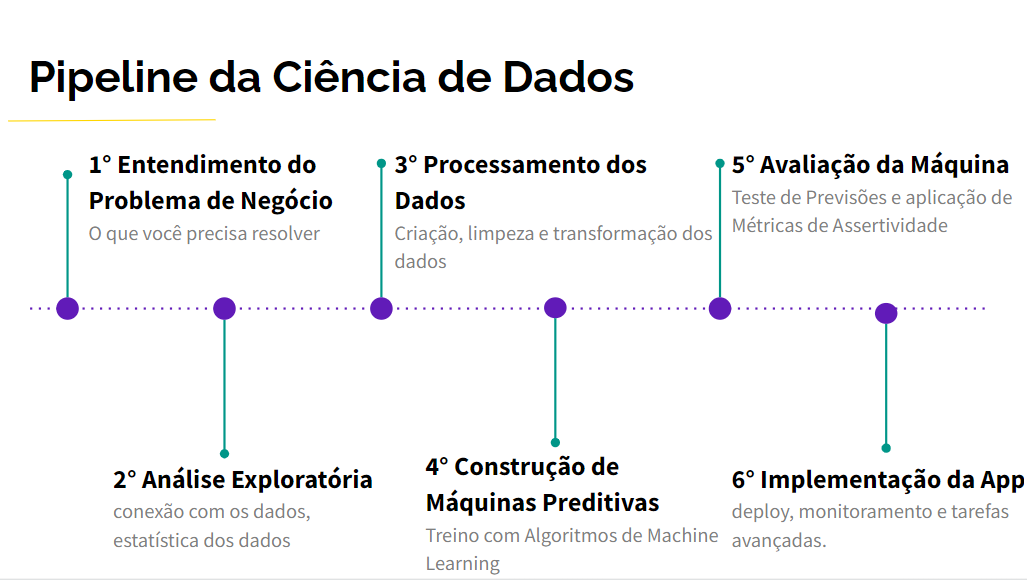

##### Importação das bibliotecas

In [189]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sweetviz as sv
import warnings
import pickle
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,plot_confusion_matrix
from lazypredict.Supervised import LazyClassifier

from scipy.stats import shapiro
warnings.filterwarnings('ignore')

# **1º** Entendimento do Problema de Negócio

#### Problema da empresa:
> A Allrede tem um dataset com informações de contratos de clientes, com o aumento de cancelamento devemos tentar identificar padrões através de máquinas preditivas para auxiliar nossos colaboradores a ter uma tratativa diferenciada a clientes com possível cancelamento de contrato. A cada linha do dataset e um serviço contrato de clientes, onde pode haver mais serviço para o mesmo cliente.

#### Objetivo:
> Desenvolver uma aplicação onde o colaborador pode selecionar o cliente da base e a máquina pereditiva da um diagnóstico sobre o status do contrato. Se ele tem chances de cancelar ou não.

# **2º** Analise Exploratória

A análise exploratória de dados consiste na técnica de examinar e estudar as características de um conjunto de dados antes de que ele seja submetido a uma aplicação, seja exclusivamente de negócio, estatística ou de aprendizagem de máquina.

*Dicionário do dataset*

Informações sobre as colunas do dataset:

1. cod_servico: Coluna contém os IDs dos serviços.
2. dia_vencimento: Coluna contém o dia dos vencimentos dos serviços.
3. valor: Coluna contém os valores dos serviços contratos pelos clientes.
4. plano: Coluna contém IDs dos plano de serviços contratos pelos clientes.
5. meses_contrato: Coluna contém a quantidade de meses de contrato dos serviços desde sua habilitação do serviço.
6. equipamento: Coluna contém dados sobres os equipamentos instalados nos serviços.
7. qtd_atendimento: Coluna contém a quantidade de atendimentos aberto neste serviço.
8. qtd_ordemservico: Coluna contém a quantidade de os aberta neste serviço.
9. cod_cidade: Coluna contém IDs das cidades onde os serviços estão instalados.
10. contrato: Contém os IDs dos status de contrato dos serviços.

##### Carregando o dataset

In [190]:
dataset_h = pd.read_csv('habilitado.csv',delimiter=';')
dataset_c = pd.read_csv('cancelado.csv',delimiter=';')
dataset = pd.concat([dataset_h,dataset_c])
print(f"Quantidade de total de registros: {dataset.shape[0]}")
print('')
print(f"{dataset['contrato'].value_counts()}")

Quantidade de total de registros: 10000

servico_habilitado    5000
cancelado             5000
Name: contrato, dtype: int64


In [191]:
# Gerando o relatorio comparativo das duas bases.
compare = sv.compare([dataset_h, 'Habilitados'],[dataset_c,'Cancelados'])
compare.show_html('compare.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report compare.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [192]:
dataset.columns

Index(['id_cliente_servico', 'dia_vencimento', 'valor', 'plano',
       'meses_contrato', 'qtd_atendimento', 'qtd_ordemservico', 'cidade',
       'contrato'],
      dtype='object')

In [193]:
dataset.set_index('id_cliente_servico',inplace=True)

In [194]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 56124 to 346872
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dia_vencimento    10000 non-null  object 
 1   valor             10000 non-null  float64
 2   plano             10000 non-null  object 
 3   meses_contrato    10000 non-null  float64
 4   qtd_atendimento   10000 non-null  int64  
 5   qtd_ordemservico  10000 non-null  int64  
 6   cidade            10000 non-null  object 
 7   contrato          10000 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 703.1+ KB


In [195]:
dataset.describe()

,valor,meses_contrato,qtd_atendimento,qtd_ordemservico
count,10000.00,10000.00,10000.00,10000.00
mean,135.68,7.32,9.95,2.23
std,469.94,12.10,17.00,13.76
min,0.00,-1199.00,0.00,0.00
25%,109.90,7.00,4.00,1.00
50%,119.90,8.00,8.00,2.00
75%,139.90,8.00,13.00,2.00
max,32942.01,9.00,1115.00,1060.00


Existe um erro na coluna de meses de contrato onde a valores muito alto e tambem inferior a 0, será tratado no passo 3.

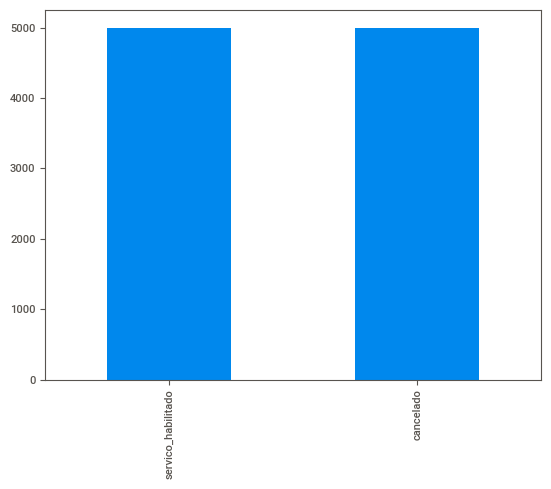

In [196]:
dataset['contrato'].value_counts().plot(kind='bar');

In [197]:
my_dataset = sv.analyze(dataset)
my_dataset.show_html('ed_data.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report ed_data.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# **3º** Processamento de dados

Processamento de dados é uma série de atividades executadas ordenadamente, que resultará em uma espécie de arranjo de informações, onde inicialmente são coletadas informações, ou dados, que passam por uma organização onde no final será o objetivo que o usuário ou sistema pretende utilizar.

##### Tranformação das colunas para categoria

In [198]:
# Copiando o dataset original para uma nova variavel
dataframe = dataset.copy()

In [199]:
#Criando apenas o dataframe com os valores correto dos meses de contrato.
dataframe = dataframe.loc[(dataframe['meses_contrato'] >= 0) & (dataframe['meses_contrato'] <= 200)]


In [200]:
# Convertendo as colunas que são numeros mais não tem peso, elas geralmente são IDs do dataset original
dataframe['contrato'] = dataframe['contrato'].astype('category')
# dataframe['cidade'] = dataframe['cidade'].astype('category')
del dataframe['cidade']
dataframe['dia_vencimento'] = dataframe['dia_vencimento'].astype('category')
dataframe['plano'] = dataframe['plano'].astype('category')
# del dataframe['plano']

In [201]:
# Total de registro por contrato do novo dataframe
dataframe['contrato'].value_counts()

servico_habilitado    5000
cancelado             4999
Name: contrato, dtype: int64

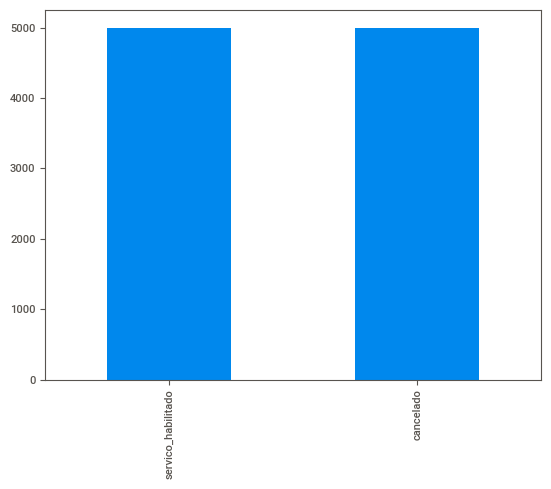

In [202]:
dataframe['contrato'].value_counts().plot.bar();

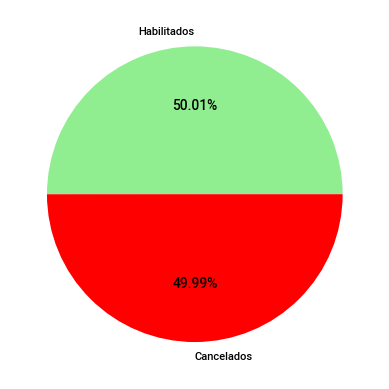

In [203]:
plt.pie(dataframe['contrato'].value_counts(),labels=['Habilitados','Cancelados'],autopct='%1.2f%%',colors=['lightgreen','red'])
plt.show()

In [204]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 56124 to 346872
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   dia_vencimento    9999 non-null   category
 1   valor             9999 non-null   float64 
 2   plano             9999 non-null   category
 3   meses_contrato    9999 non-null   float64 
 4   qtd_atendimento   9999 non-null   int64   
 5   qtd_ordemservico  9999 non-null   int64   
 6   contrato          9999 non-null   category
dtypes: category(3), float64(2), int64(2)
memory usage: 441.6 KB


O coeficiente de correlação de Pearson é um teste que mede a relação estatística entre duas variáveis contínuas. Se a associação entre os elementos não for linear, o coeficiente não será representado adequadamente.

O coeficiente de correlação de Pearson pode ter um intervalo de valores de +1 a -1. Um valor de 0 indica que não há associação entre as duas variáveis. Um valor maior que 0 indica uma associação positiva. Isto é, à medida que o valor de uma variável aumenta, o mesmo acontece com o valor da outra variável. Um valor menor que 0 indica uma associação negativa. Isto é, à medida que o valor de uma variável aumenta, o valor da outra diminui.

Fonte: [Question Pro](https://www.questionpro.com/blog/pt-br/correlacao-de-pearson/)

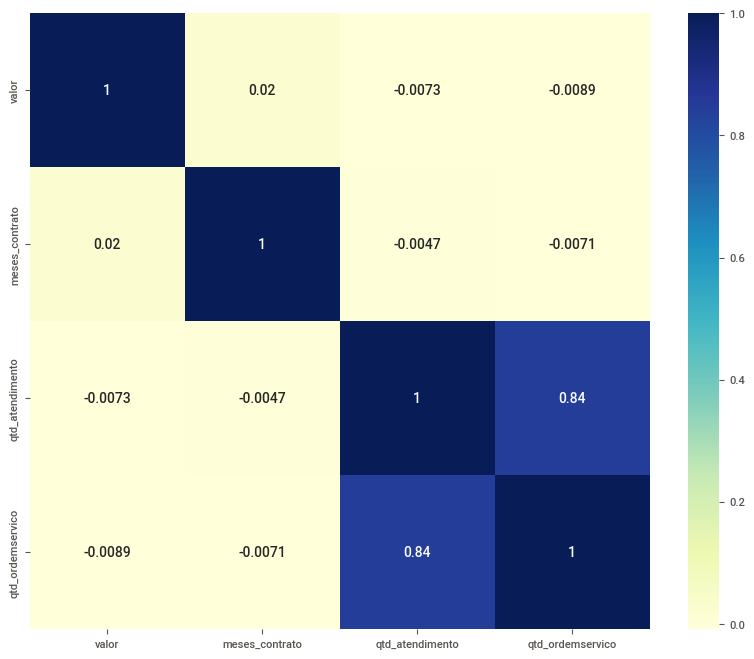

In [205]:
# Correlação de Pearson
fig3, ax3 = plt.subplots(figsize=((10,8)))
sns.heatmap(dataframe.corr(),cmap='YlGnBu',annot=True,ax=ax3)
plt.show()

##### Codificação Distribuída (One-hot encoder)
> Transforma um ou mais atributos do conjunto de dados em um, ou mais vetores binários esparsos. O One Hot Encoder é usado para transformar atributos categóricos representados como    números, porém, cuja ordem não é relevante. Para evitar que os modelos interpretem esses atributos como sendo numéricos, são criadas variáveis binárias, cada uma para um valor possível que o atributo pode assumir. Dessas novas variáveis binárias, a única que terá valor 1 será correspondente à categoria do atributo na instância.

In [206]:
onehotenconder = OneHotEncoder()
X_cat = dataframe[['dia_vencimento','plano']] #[['dia_vencimento','plano','cidade']]
X_cat = onehotenconder.fit_transform(X_cat).toarray()   

In [207]:
X_cat = pd.DataFrame(X_cat)

##### Normalização dos Dados
> A normalização é uma técnica geralmente aplicada como parte da preparação de dados para o aprendizado de máquina. O objetivo da normalização é mudar os valores das colunas numéricas no conjunto de dados para usar uma escala comum, sem distorcer as diferenças nos intervalos de valores nem perder informações. A normalização também é necessária para alguns algoritmos para modelar os dados corretamente.

> Por exemplo, suponha que o conjunto de dados de entrada contenha uma coluna com valores variando de 0 a 1 e outra coluna com valores variando de 10.000 a 100.000. A grande diferença na escala dos números pode causar problemas ao tentar combinar os valores como recursos durante a modelagem.

> A normalização evita esses problemas criando novos valores que mantêm a distribuição geral e as proporções nos dados de origem, mantendo os valores em uma escala aplicada em todas as colunas numéricas usadas no modelo.

In [208]:
X_num = dataframe[['valor','meses_contrato','qtd_atendimento','qtd_ordemservico']]

In [209]:
X_num.reset_index(inplace=True)
del X_num['id_cliente_servico']
X_num

,valor,meses_contrato,qtd_atendimento,qtd_ordemservico
0,19.90,8.00,1,1
1,169.90,9.00,5,1
2,0.00,5.00,19,1
3,119.90,6.00,10,3
4,139.90,4.00,49,3
...,...,...,...,...
9994,0.00,7.00,0,0
9995,0.00,7.00,0,0
9996,0.00,7.00,0,0
9997,0.00,7.00,0,4


In [210]:
X_all = pd.concat([X_cat,X_num],axis=1,ignore_index=True)

In [211]:
min_max = MinMaxScaler()
X = min_max.fit_transform(X_all)

In [212]:
y = dataframe.values[:,-1]

##### Train and Test

*Train*
> Conforme podemos imaginar, dados de treino são os dados que serão apresentados ao algoritmo de machine learning para criação do modelo. Estes dados costumam representar cerca de 70% da totalidade dos dados.

*Test*
> São os dados que serão apresentados ao modelo após a sua criação, simulando previsões reais que o modelo realizará, permitindo assim que o desempenho real seja verificado. Estes dados costumam representar cerca de 30% da totalidade dos dados.

*Stratify*
>   Muitas vezes a população se divide em subpopulações ou estratos, sendo razoável supor que, de estrato para estrato, a variável de interesse apresente um comportamento substancialmente diverso, tendo, entretanto, comportamento razoavelmente homogêneo dentro de cada estrato. Em tais casos, se o sorteio dos elementos da amostra for realizado sem se levar em consideração a existência dos estratos, pode acontecer que os diversos estratos não sejam convenientemente representados na amostra, a qual seria mais influenciada pelas características da variável nos estratos mais favorecidos pelo sorteio. Evidentemente, a tendência da ocorrência de tal fato será tanto maior quanto menor o tamanho da amostra. Para evitar isso, pode-se adotar uma amostragem estratificada.


In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

##### Lazy Predict (Buscando melhor algoritimo)
> Lazy Predict ajuda a construir um monte de modelos básicos sem muito código e ajuda a entender quais modelos funcionam melhor sem qualquer ajuste de parâmetro

In [214]:
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [01:46<00:00,  3.68s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.84,0.84,None,0.84,0.38
RandomForestClassifier,0.84,0.84,None,0.84,2.17
LogisticRegression,0.83,0.83,None,0.83,0.60
NearestCentroid,0.83,0.83,None,0.83,0.18
BaggingClassifier,0.83,0.83,None,0.83,1.25
KNeighborsClassifier,0.83,0.83,None,0.83,0.33
RidgeClassifierCV,0.83,0.83,None,0.83,0.57
RidgeClassifier,0.83,0.83,None,0.83,0.24
LinearDiscriminantAnalysis,0.83,0.83,None,0.83,0.78


# 4º Construção de Máquinas Preditivas

In [215]:
param_grid = {
    'max_depth': [None,4,5,6,7,8,9],
    'max_features': ['auto','sqrt'],
    'n_estimators': [20,50,100]
}

In [216]:
rfc = RandomForestClassifier()

In [217]:
cf_cv = GridSearchCV(estimator=rfc,param_grid=param_grid,cv=3)
cf_cv.fit(X_train,y_train)
cf_cv.best_params_

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

In [218]:
rfc2 = RandomForestClassifier(**cf_cv.best_params_)
rfc2.fit(X_train,y_train)

RandomForestClassifier()

In [219]:
predict = rfc2.predict(X_test)

# 5º Avaliação da Máquina

In [220]:
print(classification_report(y_test,predict))

                    precision    recall  f1-score   support

         cancelado       0.85      0.82      0.83      1000
servico_habilitado       0.83      0.85      0.84      1000

          accuracy                           0.84      2000
         macro avg       0.84      0.84      0.84      2000
      weighted avg       0.84      0.84      0.84      2000



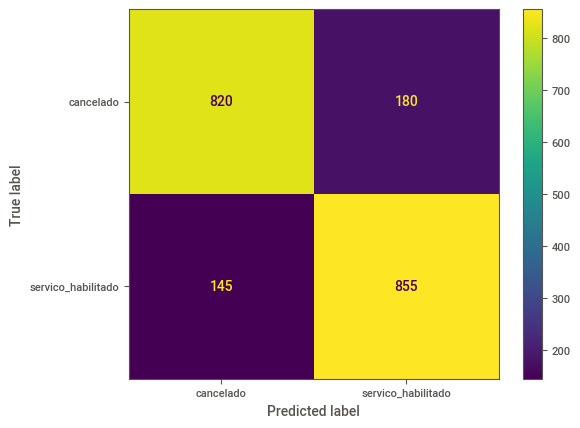

In [221]:
plot_confusion_matrix(rfc2,X_test,y_test)

In [222]:
resultado_rfc = []
for i in range(3):
    kfold = KFold(n_splits=10,shuffle=True,random_state=i)
    scores = cross_val_score(rfc2,X,y,cv=kfold)
    resultado_rfc.append(scores.mean())
resultado_rfc = np.array(resultado_rfc)

In [223]:
alpha = 0.5
shapiro(resultado_rfc)

ShapiroResult(statistic=0.8984260559082031, pvalue=0.3805079460144043)

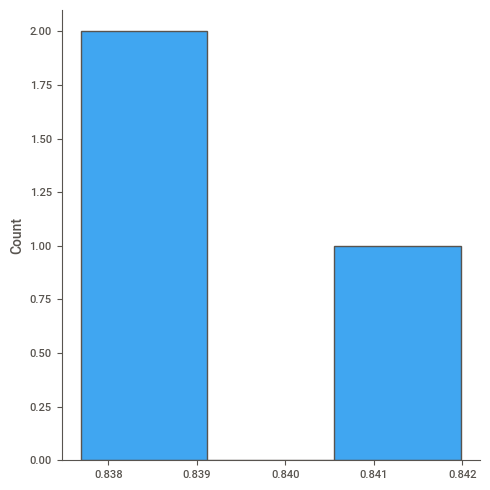

In [224]:
sns.displot(resultado_rfc)

# 6º Implementação do App

In [225]:
pickle.dump(rfc2,open('modelo_cancelamento.sav','wb'))

In [226]:
teste = pickle.load(open('modelo_cancelamento.sav','rb'))

In [227]:
teste.predict()

TypeError: ForestClassifier.predict() missing 1 required positional argument: 'X'